In [6]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
from datetime import datetime

In [7]:
inicio = dt.date(2015, 1, 1)
fim = datetime.now()

In [8]:


lista_acoes = ['AAPL', "NKE", "GOOGL", "AMZN", "NVDA", "MSFT"]

precos = yf.download(lista_acoes, inicio, fim)['Adj Close']
precos

[*********************100%%**********************]  6 of 6 completed


,AAPL,AMZN,GOOGL,MSFT,NKE,NVDA
Date,,,,,,
2015-01-02,24.373957,15.426000,26.447147,40.232857,42.759666,0.483218
2015-01-05,23.687300,15.109500,25.943224,39.862877,42.071247,0.475057
2015-01-06,23.689537,14.764500,25.302961,39.277790,41.823746,0.460654
2015-01-07,24.021717,14.921000,25.228544,39.776833,42.687656,0.459453
2015-01-08,24.944681,15.023000,25.316446,40.946999,43.673096,0.476737
...,...,...,...,...,...,...
2024-08-26,227.179993,175.500000,166.160004,413.489990,84.279999,126.459999
2024-08-27,228.029999,173.119995,164.679993,413.839996,85.290001,128.300003
2024-08-28,226.490005,170.800003,162.850006,410.600006,82.790001,125.610001


In [9]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() #Retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [12]:
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):

    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos

    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))

    vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]


In [13]:
indice_do_sharpe_maximo = vetor_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo] #Carteira recomendada pela otimização

array([0.0729036 , 0.11188382, 0.01065182, 0.21147822, 0.01445748,
       0.57862506])

In [14]:
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

tabela_retornos_esperados_arit 

array([0.25083712, 0.37091883, 0.31266487, ..., 0.25406316, 0.31680134,
       0.27046534])

In [15]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(),
                                         tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) *252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste) -1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))

    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0,1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:

    #Pegar melhor volatilidade para cada retorno

    restricoes = ({'type': 'eq', 'fun': checando_soma_pesos},
                  {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites,
                      constraints= restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

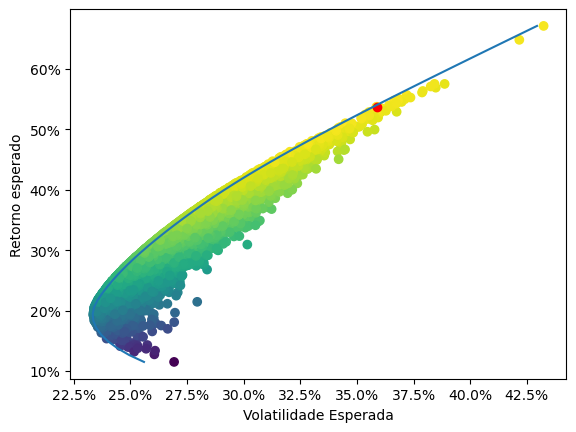

In [17]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel("Volatilidade Esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[indice_do_sharpe_maximo],
           tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()
